# 1. Imports

In [1]:
import json
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from time import time, sleep

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

# Gensim for Dense Embeddings
from gensim.models import FastText #Word2Vec

# NLTK downloads
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# --- MANDATORY: REPRODUCIBILITY (Section 3.1.3) ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 2. Dataset

## 2.1 Dataset loading

In [2]:
# ==========================================
# 1. DATA LOADING & LABEL ENGINEERING
# ==========================================
def load_and_parse_data(filepath):
    """
    Parses nested JSON and applies Majority Voting for labels.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.reset_index().rename(columns={'index': 'id_EXIST'})
    
    # Label Processing (Majority Voting)
    if 'labels_task1_1' in df.columns:
        def get_majority_vote(labels_list):
            if not isinstance(labels_list, list): return np.nan
            counts = pd.Series(labels_list).value_counts()
            # Tie-breaking: Prioritize 'YES' (Sexism) if tie
            if len(counts) > 1 and counts.iloc[0] == counts.iloc[1]:
                if 'YES' in counts.index[:2]: return 'YES'
            return counts.idxmax()
        
        df['final_label_str'] = df['labels_task1_1'].apply(get_majority_vote)
        df['label'] = df['final_label_str'].map({'YES': 1, 'NO': 0})
        df = df.dropna(subset=['label'])
        df['label'] = df['label'].astype(int)
        
    return df

print("Loading Data...")
df_train = load_and_parse_data('../data/training/EXIST2025_training.json')
df_val = load_and_parse_data('../data/dev/EXIST2025_dev.json')
df_test = load_and_parse_data('../data/test/EXIST2025_test_clean.json')

print(f"\nTotal Samples - Training: {len(df_train)}")
print(df_train['final_label_str'].value_counts())

print(f"\nTotal Samples - Validation: {len(df_val)}")
print(df_val['final_label_str'].value_counts())

print(f"\nTotal Samples - Test: {len(df_test)}")
try:
    print(df_test['final_label_str'].value_counts())
except:
    print(f"No labels available for this data split")

Loading Data...

Total Samples - Training: 6920
final_label_str
YES    3553
NO     3367
Name: count, dtype: int64

Total Samples - Validation: 1038
final_label_str
YES    559
NO     479
Name: count, dtype: int64

Total Samples - Test: 2076
No labels available for this data split


## 2.2 Data Splits and Class Distribution

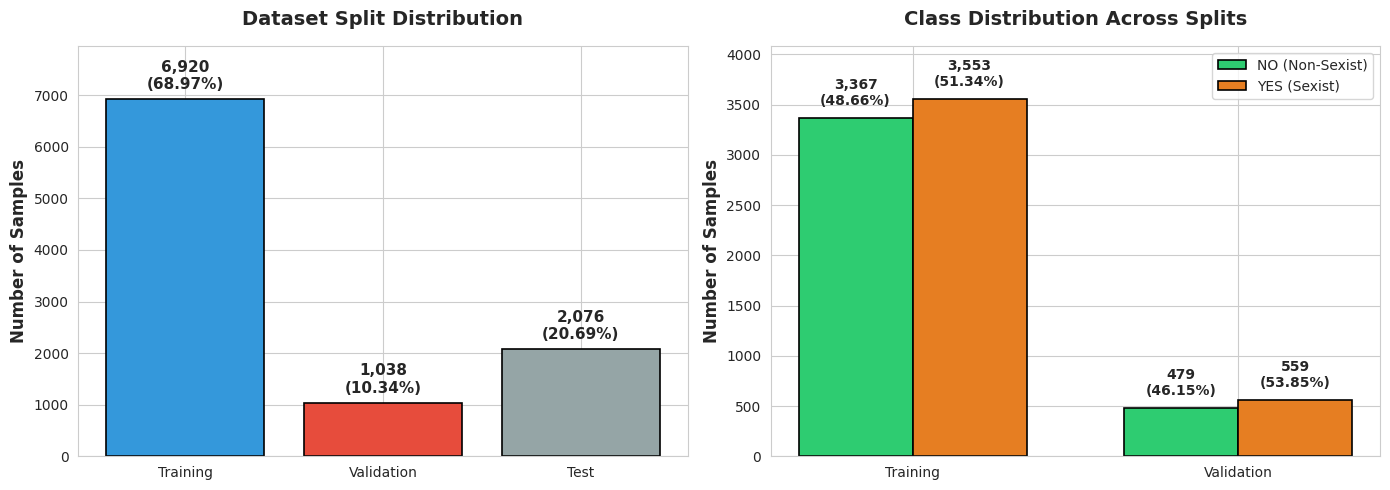

In [3]:
# ==========================================
# DATA DISTRIBUTION VISUALIZATION
# ==========================================

# Prepare data for plotting
split_names = ['Training', 'Validation', 'Test']
split_counts = [len(df_train), len(df_val), len(df_test)]
split_percentages = [count / sum(split_counts) * 100 for count in split_counts]

# Class distribution data
class_dist_data = {
    'Training': [
        (df_train['final_label_str'] == 'NO').sum(),
        (df_train['final_label_str'] == 'YES').sum()
    ],
    'Validation': [
        (df_val['final_label_str'] == 'NO').sum(),
        (df_val['final_label_str'] == 'YES').sum()
    ],
    'Test': [0, 0]  # No labels
}

# Set style
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Data Split Distribution
colors_split = ['#3498db', '#e74c3c', '#95a5a6']
bars1 = axes[0].bar(split_names, split_counts, color=colors_split, edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylim(0, max(split_counts) * 1.15)

# Add count and percentage labels
for bar, count, pct in zip(bars1, split_counts, split_percentages):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + max(split_counts)*0.02,
                f'{count:,}\n({pct:.2f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Remove Test split for the second plot (because we don't have info about labels)
split_names = split_names[:-1]
split_counts = split_counts[:-1]
split_percentages = split_percentages[:-1]

# Plot 2: Class Distribution by Split
x = np.arange(len(split_names))
width = 0.35
colors_class = ['#2ecc71', '#e67e22']

bars_no = axes[1].bar(x - width/2, [class_dist_data[split][0] for split in split_names], 
                       width, label='NO (Non-Sexist)', color=colors_class[0], 
                       edgecolor='black', linewidth=1.2)
bars_yes = axes[1].bar(x + width/2, [class_dist_data[split][1] for split in split_names], 
                        width, label='YES (Sexist)', color=colors_class[1], 
                        edgecolor='black', linewidth=1.2)

axes[1].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1].set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x)
axes[1].set_xticklabels(split_names)
axes[1].legend(fontsize=10, loc='upper right')
axes[1].set_ylim(0, max([max(class_dist_data[split]) for split in split_names]) * 1.15)

# Add value and percentage labels on bars
for i, split in enumerate(split_names):
    
    total = sum(class_dist_data[split])
    
    # NO bars
    height_no = bars_no[i].get_height()
    if height_no > 0:
        pct_no = (height_no / total * 100) if total > 0 else 0
        axes[1].text(bars_no[i].get_x() + bars_no[i].get_width()/2., height_no + 100,
                    f'{int(height_no):,}\n({pct_no:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # YES bars
    height_yes = bars_yes[i].get_height()
    if height_yes > 0:
        pct_yes = (height_yes / total * 100) if total > 0 else 0
        axes[1].text(bars_yes[i].get_x() + bars_yes[i].get_width()/2., height_yes + 100,
                    f'{int(height_yes):,}\n({pct_yes:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../report/figures/data_splits_and_class_distribution.pdf', dpi=80)
plt.show()

## 2.3 Dataset and Vocabulary Statistics

In [4]:
def compute_avg_text_length(df):
    """
    Computes the average text length (in words) of tweets in the dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing a 'tweet' column with text data
    
    Returns:
    --------
    float
        Average text length across all tweets
    """
    total_words = 0
    total_tweets = 0
    
    for tweet in df['tweet']:
        if isinstance(tweet, str):
            words = tweet.split()
            total_words += len(words)
            total_tweets += 1
    
    if total_tweets == 0:
        return 0.0
    
    return total_words / total_tweets

# Usage examples:
avg_text_len_train = compute_avg_text_length(df_train)
avg_text_len_val = compute_avg_text_length(df_val)
avg_text_len_test = compute_avg_text_length(df_test)

print(f"Average text length (words) - Training: {avg_text_len_train:.2f}")
print(f"Average text length (words) - Validation: {avg_text_len_val:.2f}")
print(f"Average text length (words) - Test: {avg_text_len_test:.2f}")

Average text length (words) - Training: 28.14
Average text length (words) - Validation: 28.58
Average text length (words) - Test: 27.87


# 3. Ablation Studies

## 3.1 Preprocessing Ablation Study

In [5]:
# ==========================================
# 2. PREPROCESSING ABLATION STUDY (Section 4.2)
# ==========================================
print("\n--- 4.2 PREPROCESSING ABLATION STUDY ---")

stop_words = set(stopwords.words('english')) | set(stopwords.words('spanish'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, strategy='raw'):
    """
    Implements the specific strategies defined in Section 4.2.1
    """
    text_processed = str(text)
    
    if strategy == 'raw':
        return text_processed
        
    if strategy == 'lowercase':
        return text_processed.lower()
        
    if strategy == 'no_punct':
        # Remove punctuation, keep spaces
        text_processed = re.sub(r'[^\w\s]', '', text_processed)
        return text_processed.lower()
        
    if strategy == 'no_stopwords':
        text_processed = text_processed.lower()
        words = text_processed.split()
        return " ".join([w for w in words if w not in stop_words])
        
    if strategy == 'stemmed':
        text_processed = text_processed.lower()
        words = text_processed.split()
        return " ".join([stemmer.stem(w) for w in words])
        
    if strategy == 'lemmatized':
        text_processed = text_processed.lower()
        # Simple tokenization for lemmatizer
        words = text_processed.split() 
        return " ".join([lemmatizer.lemmatize(w) for w in words])
        
    return text_processed

# We need to split data FIRST to avoid data leakage (Section 3.1)
# Using 'raw' text as the base source
X_train_raw = df_train['tweet']
y_train = df_train['label']

X_val_raw = df_val['tweet']
y_val = df_val['label']

# X_test_raw = df_test['tweet']
# y_test = df_test['label']

# Stratified Split (Section 3.1.2)
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(
#     X_raw, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
# )

strategies = ['raw', 'lowercase', 'no_punct', 'no_stopwords', 'stemmed', 'lemmatized']
ablation_results = {}

for strat in strategies:
    print(f"Testing strategy: {strat}...")
    # Apply preprocessing
    prep_start_time = time()
    X_train_curr = [preprocess_text(text, strat) for text in X_train_raw]
    X_val_curr = [preprocess_text(text, strat) for text in X_val_raw]
    prep_end_time = time()
    prep_time = prep_end_time - prep_start_time

    # Pipeline: TF-IDF (Default) + LR (Default)
    pipe = Pipeline([
        ('vect', TfidfVectorizer(lowercase=False)),
        ('clf', LogisticRegression(max_iter=2000, random_state=42))
    ])
    
    # 5-Fold Stratified CV (Section 3.4.1)
    fit_start_time = time()
    pipe.fit(X_train_curr, y_train)
    fit_end_time = time()
    fit_time = fit_end_time - fit_start_time

    preds = pipe.predict(X_val_curr)
    scores = f1_score(preds, y_val, average = "macro")
    
    ablation_results[strat] = f"Vocab-Size: {len(pipe['vect'].vocabulary_)} | F1-Score: {scores:.4f} | Preprocess-Time: {prep_time:.3f} s | Fit-Time: {fit_time:.3f} s"

print("\nPreprocessing Results:")
for k, v in ablation_results.items():
    print(f"{k}: {v}")


--- 4.2 PREPROCESSING ABLATION STUDY ---
Testing strategy: raw...
Testing strategy: lowercase...
Testing strategy: no_punct...
Testing strategy: no_stopwords...
Testing strategy: stemmed...
Testing strategy: lemmatized...

Preprocessing Results:
raw: Vocab-Size: 41614 | F1-Score: 0.7291 | Preprocess-Time: 0.002 s | Fit-Time: 0.305 s
lowercase: Vocab-Size: 37033 | F1-Score: 0.7455 | Preprocess-Time: 0.008 s | Fit-Time: 0.241 s
no_punct: Vocab-Size: 38335 | F1-Score: 0.7363 | Preprocess-Time: 0.050 s | Fit-Time: 0.235 s
no_stopwords: Vocab-Size: 36943 | F1-Score: 0.7478 | Preprocess-Time: 0.048 s | Fit-Time: 0.252 s
stemmed: Vocab-Size: 34933 | F1-Score: 0.7494 | Preprocess-Time: 1.627 s | Fit-Time: 0.240 s
lemmatized: Vocab-Size: 36430 | F1-Score: 0.7408 | Preprocess-Time: 2.962 s | Fit-Time: 0.222 s


In [7]:
# Prepare Data with Best Strategy
X_train = [preprocess_text(t, 'stemmed') for t in X_train_raw]
X_val = [preprocess_text(t, 'stemmed') for t in X_val_raw]
# X_test = [preprocess_text(t, 'stemmed') for t in X_test_raw]

## 3.2 N-Gram Ablation Study

In [9]:
# ==========================================
# 3. N-GRAM EXPLORATION (Section 4.1)
# ==========================================
print("\n--- 4.1 N-GRAM EXPLORATION ---")
ngram_configs = [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
ngram_results = {}

for ngram in ngram_configs:
    pipe = Pipeline([
        ('vect', TfidfVectorizer(lowercase = False, ngram_range = ngram)),
        ('clf', LogisticRegression(max_iter=2000, random_state=42))
    ])
    
    fit_start_time = time()
    pipe.fit(X_train, y_train)
    fit_end_time = time()
    fit_time = fit_end_time - fit_start_time

    preds = pipe.predict(X_val)
    scores = f1_score(preds, y_val, average = "macro")
    
    ngram_results[str(ngram)] = f"Vocab-Size: {len(pipe['vect'].vocabulary_)} | F1-Score: {scores:.4f} | Fit-Time: {fit_time:.3f} s"

    print(f"N-gram {ngram}: {ngram_results[str(ngram)]}")


--- 4.1 N-GRAM EXPLORATION ---
N-gram (1, 1): Vocab-Size: 34933 | F1-Score: 0.7494 | Fit-Time: 0.449 s
N-gram (1, 2): Vocab-Size: 156392 | F1-Score: 0.7354 | Fit-Time: 1.387 s
N-gram (1, 3): Vocab-Size: 319588 | F1-Score: 0.7240 | Fit-Time: 2.698 s
N-gram (2, 2): Vocab-Size: 121459 | F1-Score: 0.6809 | Fit-Time: 1.192 s
N-gram (2, 3): Vocab-Size: 284655 | F1-Score: 0.6725 | Fit-Time: 2.621 s
N-gram (3, 3): Vocab-Size: 163196 | F1-Score: 0.5554 | Fit-Time: 1.045 s


# 4. Sparse Hyperparameter Optimization

In [18]:
# ==========================================
# 1. PREPARE THE "PREDEFINED SPLIT"
# ==========================================

X_combined = X_train + X_val 
y_combined = pd.concat([y_train, y_val])

# Create the index array for the split
# The first len(X_train) indices are -1 (Train), the rest are 0 (Validation)
split_index = [-1]*len(X_train) + [0]*len(X_val)
pds = PredefinedSplit(test_fold=split_index)

print(f"Combined Data: {len(X_combined)} samples.")
print(f"Training: {len(X_train)} | Validation: {len(X_val)}")

# ==========================================
# 2. DEFINE PIPELINES AND PARAMETERS
# ==========================================

# --- CONFIGURATION A: LOGISTIC REGRESSION ---
pipe_lr = Pipeline([
    ('vect', TfidfVectorizer(lowercase = False, ngram_range = (1, 1))),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

param_grid_lr = {
    # TF-IDF Params (Your new hyperparameters)
    'vect__min_df': [1, 2, 5],         # 1=Keep all, 2=Remove unique words (noise)
    'vect__binary': [True, False],  # Does frequency matter or just presence?
    'vect__sublinear_tf': [True, False], # Logarithmic smoothing (log(1+tf))
    'vect__max_features': [15000, 25000, 35000], 
    
    # LR Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# --- CONFIGURATION B: SVM (LinearSVC) ---
pipe_svm = Pipeline([
    ('vect', TfidfVectorizer(lowercase = False, ngram_range = (1, 1))),
    ('clf', LinearSVC(random_state=42, dual='auto'))
])

param_grid_svm = {
    'vect__min_df': [1, 2, 5],
    'vect__binary': [True, False],
    'vect__sublinear_tf': [True, False],
    'vect__max_features': [15000, 25000, 35000], 
    
    # SVM Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# ==========================================
# 3. EXECUTE GRID SEARCH (WITH YOUR FIXED SPLIT)
# ==========================================

# NOTE: We pass cv=pds to force using your X_val as the only validation set
print("\n--- Searching for best hyperparameters (Logistic Regression) ---")
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=pds, scoring='f1_macro', n_jobs=4, verbose=3, refit = True)
grid_lr.fit(X_combined, y_combined) # We pass EVERYTHING, it knows what to split thanks to 'pds'

print("=" * 60, "\n")

print("\n--- Searching for best hyperparameters (SVM - LinearSVC) ---")
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=pds, scoring='f1_macro', n_jobs=4, verbose=3, refit = True)
grid_svm.fit(X_combined, y_combined)

print("=" * 60, "\n")

print(f"Best LR F1: {grid_lr.best_score_:.4f}")
print(f"Best LR Params: {grid_lr.best_params_}")
print()
print(f"Best SVM F1: {grid_svm.best_score_:.4f}")
print(f"Best SVM Params: {grid_svm.best_params_}")

Combined Data: 7958 samples.
Training: 6920 | Validation: 1038

--- Searching for best hyperparameters (Logistic Regression) ---
Fitting 1 folds for each of 216 candidates, totalling 216 fits
[CV 1/1] END clf__C=0.1, clf__class_weight=None, vect__binary=True, vect__max_features=15000, vect__min_df=1, vect__sublinear_tf=True;, score=0.716 total time=   0.2s
[CV 1/1] END clf__C=0.1, clf__class_weight=None, vect__binary=True, vect__max_features=15000, vect__min_df=5, vect__sublinear_tf=True;, score=0.721 total time=   0.2s
[CV 1/1] END clf__C=0.1, clf__class_weight=None, vect__binary=True, vect__max_features=15000, vect__min_df=5, vect__sublinear_tf=False;, score=0.721 total time=   0.2s
[CV 1/1] END clf__C=0.1, clf__class_weight=None, vect__binary=True, vect__max_features=25000, vect__min_df=1, vect__sublinear_tf=True;, score=0.718 total time=   0.2s
[CV 1/1] END clf__C=0.1, clf__class_weight=None, vect__binary=True, vect__max_features=25000, vect__min_df=1, vect__sublinear_tf=False;, sc

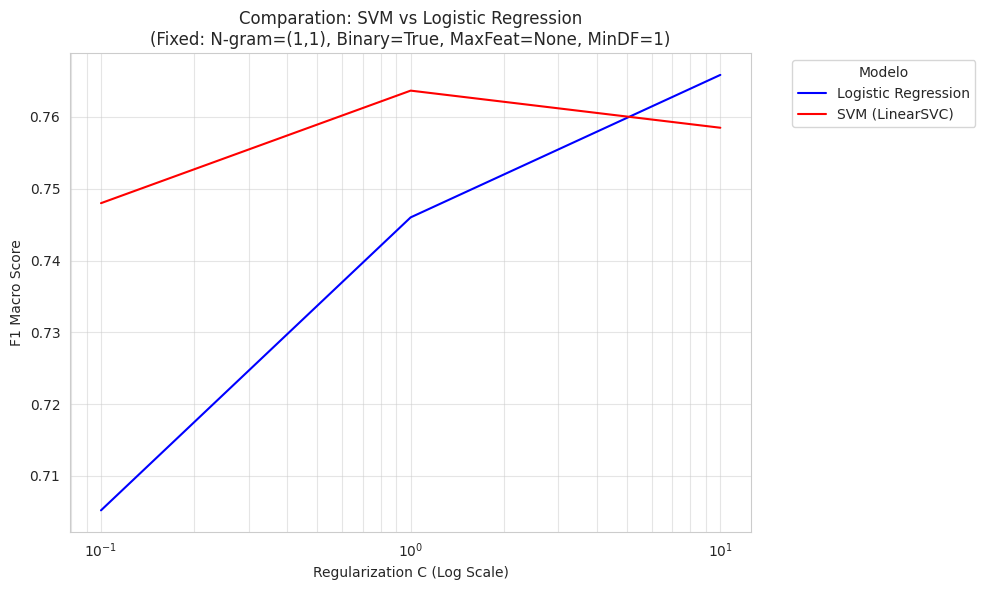

In [19]:
df_lr = pd.DataFrame(grid_lr.cv_results_)
df_lr['Model'] = 'Logistic Regression'

df_svm = pd.DataFrame(grid_svm.cv_results_)
df_svm['Model'] = 'SVM (LinearSVC)'

df_all = pd.concat([df_lr, df_svm])
df_all['param_vect__max_features'] = df_all['param_vect__max_features'].fillna('None')

subset = df_all[
    (df_all['param_vect__binary'] == True) &
    (df_all['param_vect__max_features'] == 35000) &
    (df_all['param_vect__min_df'] == 1) &
    (df_all['param_vect__sublinear_tf'] == True) &
    (df_all['param_clf__class_weight'] == 'balanced')
]

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset,
    x='param_clf__C',
    y='mean_test_score',
    hue='Model',
    markers=True,
    dashes=False,
    palette={'Logistic Regression': 'blue', 'SVM (LinearSVC)': 'red'}
)

plt.xscale('log')
plt.title('Comparation: SVM vs Logistic Regression\n(Fixed: N-gram=(1,1), Binary=True, MaxFeat=None, MinDF=1)')
plt.xlabel('Regularization C (Log Scale)')
plt.ylabel('F1 Macro Score')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

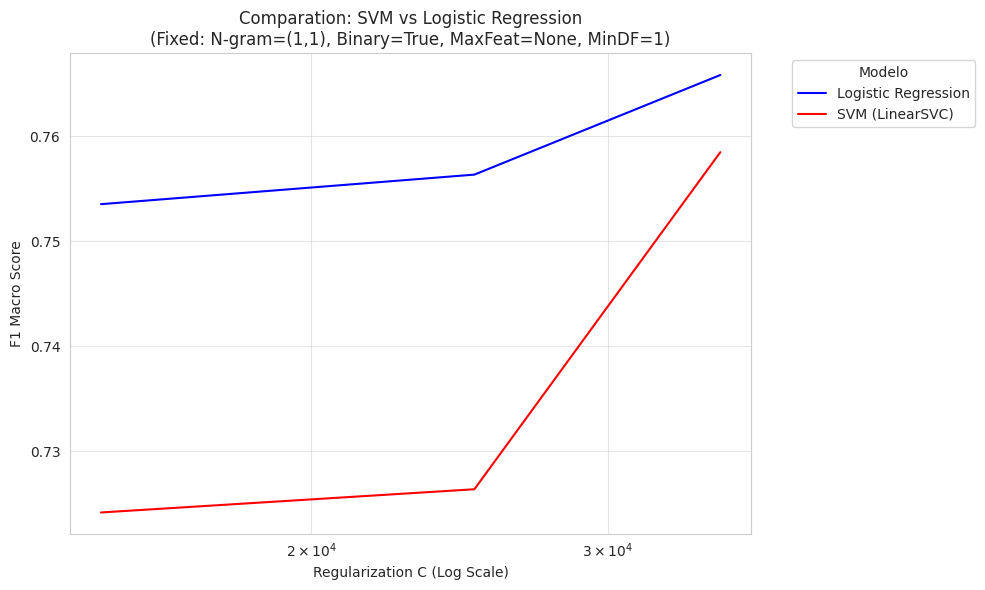


[CV 1/1] END clf__C=10, clf__class_weight=None, vect__binary=False, vect__max_features=25000, vect__min_df=5, vect__sublinear_tf=False;, score=0.717 total time=   0.6s
[CV 1/1] END clf__C=10, clf__class_weight=None, vect__binary=False, vect__max_features=35000, vect__min_df=2, vect__sublinear_tf=False;, score=0.715 total time=   0.6s
[CV 1/1] END clf__C=10, clf__class_weight=balanced, vect__binary=True, vect__max_features=15000, vect__min_df=2, vect__sublinear_tf=False;, score=0.714 total time=   0.7s
[CV 1/1] END clf__C=10, clf__class_weight=balanced, vect__binary=True, vect__max_features=25000, vect__min_df=2, vect__sublinear_tf=True;, score=0.714 total time=   0.5s
[CV 1/1] END clf__C=10, clf__class_weight=balanced, vect__binary=True, vect__max_features=25000, vect__min_df=5, vect__sublinear_tf=True;, score=0.707 total time=   0.3s
[CV 1/1] END clf__C=10, clf__class_weight=balanced, vect__binary=True, vect__max_features=35000, vect__min_df=2, vect__sublinear_tf=True;, score=0.714 t

In [23]:
df_lr = pd.DataFrame(grid_lr.cv_results_)
df_lr['Model'] = 'Logistic Regression'

df_svm = pd.DataFrame(grid_svm.cv_results_)
df_svm['Model'] = 'SVM (LinearSVC)'

df_all = pd.concat([df_lr, df_svm])
df_all['param_vect__max_features'] = df_all['param_vect__max_features'].fillna('None')

subset = df_all[
    (df_all['param_vect__binary'] == True) &
    (df_all['param_clf__C'] == 10) &
    (df_all['param_vect__min_df'] == 1) &
    (df_all['param_vect__sublinear_tf'] == True) &
    (df_all['param_clf__class_weight'] == 'balanced')
]

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset,
    x='param_vect__max_features',
    y='mean_test_score',
    hue='Model',
    markers=True,
    dashes=False,
    palette={'Logistic Regression': 'blue', 'SVM (LinearSVC)': 'red'}
)

plt.xscale('log')
plt.title('Comparation: SVM vs Logistic Regression\n(Fixed: N-gram=(1,1), Binary=True, MaxFeat=None, MinDF=1)')
plt.xlabel('Regularization C (Log Scale)')
plt.ylabel('F1 Macro Score')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

# 5. Dense (FastText) Optimization

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from gensim.models import FastText

# ==========================================
# 1. PREPARE THE "PREDEFINED SPLIT"
# ==========================================
# Combine data just like we did for the Sparse case
# X_train and X_val are lists -> Use '+'
X_combined = X_train + X_val 

# y_train and y_val are Series -> Use pd.concat
y_combined = pd.concat([y_train, y_val])

# Create the index: -1 for Train, 0 for Validation
split_index = [-1]*len(X_train) + [0]*len(X_val)
pds = PredefinedSplit(test_fold=split_index)

print(f"Combined Data for FastText: {len(X_combined)} samples.")
print(f"Training: {len(X_train)} | Validation: {len(X_val)}")

# ==========================================
# 2. DEFINE VECTORIZER CLASS & PIPELINE
# ==========================================

class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        sentences = [row.split() for row in X]
        # Train FastText
        self.model = FastText(sentences, 
                              vector_size=self.vector_size, 
                              window=self.window, 
                              min_count=self.min_count, 
                              workers=4, 
                              seed=42)
        return self

    def transform(self, X):
        # Note: FastText can infer vectors for OOV (Out-Of-Vocabulary) words.
        # If the word is in the vocabulary (self.model.wv), we use it.
        # If not, FastText usually calculates it via n-grams. 
        # Here we use safe logic to avoid errors if the model is not ready.
        return np.array([
            np.mean([self.model.wv[w] for w in words if w in self.model.wv]
                    or [np.zeros(self.vector_size)], axis=0)
            for words in [row.split() for row in X]
        ])

# --- CONFIGURATION A: LOGISTIC REGRESSION ---
pipe_dense_lr = Pipeline([
    ('vect', MeanEmbeddingVectorizer()),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

param_grid_dense_lr = {
    'vect__vector_size': [100, 300],   # Vector Dimensions
    'vect__window': [3, 5],            # Context windows
    
    # LR Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# --- CONFIGURATION B: SVM (LinearSVC) ---
pipe_dense_svm = Pipeline([
    ('vect', MeanEmbeddingVectorizer()),
    ('clf', LinearSVC(random_state=42, dual='auto'))
])

param_grid_dense_svm = {
    'vect__vector_size': [100, 300],   # Vector Dimensions
    'vect__window': [3, 5],            # Context windows
    
    # SVM Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# ==========================================
# 3. EXECUTE GRID SEARCH (WITH YOUR FIXED SPLIT)
# ==========================================

# NOTE: We pass cv=pds to force using your X_val as the only validation set
print("\n--- Searching for best hyperparameters (Logistic Regression) ---")
grid_dense_lr = GridSearchCV(pipe_dense_lr, param_grid_dense_lr, cv=pds, scoring='f1_macro', n_jobs=4, verbose=3, refit = True)
grid_dense_lr.fit(X_combined, y_combined) # We pass EVERYTHING, it knows what to split thanks to 'pds'
print("=" * 60, "\n")

print("\n--- Searching for best hyperparameters (SVM - LinearSVC) ---")
grid_dense_svm = GridSearchCV(pipe_dense_svm, param_grid_dense_svm, cv=pds, scoring='f1_macro', n_jobs=4, verbose=3, refit = True)
grid_dense_svm.fit(X_combined, y_combined)
print("=" * 60, "\n")

print(f"Best LR F1: {grid_dense_lr.best_score_:.4f}")
print(f"Best LR Params: {grid_dense_lr.best_params_}")
print()
print(f"Best SVM F1: {grid_dense_svm.best_score_:.4f}")
print(f"Best SVM Params: {grid_dense_svm.best_params_}")

Combined Data for FastText: 7958 samples.
Training: 6920 | Validation: 1038

--- Searching for best hyperparameters (Logistic Regression) ---
Fitting 1 folds for each of 24 candidates, totalling 24 fits


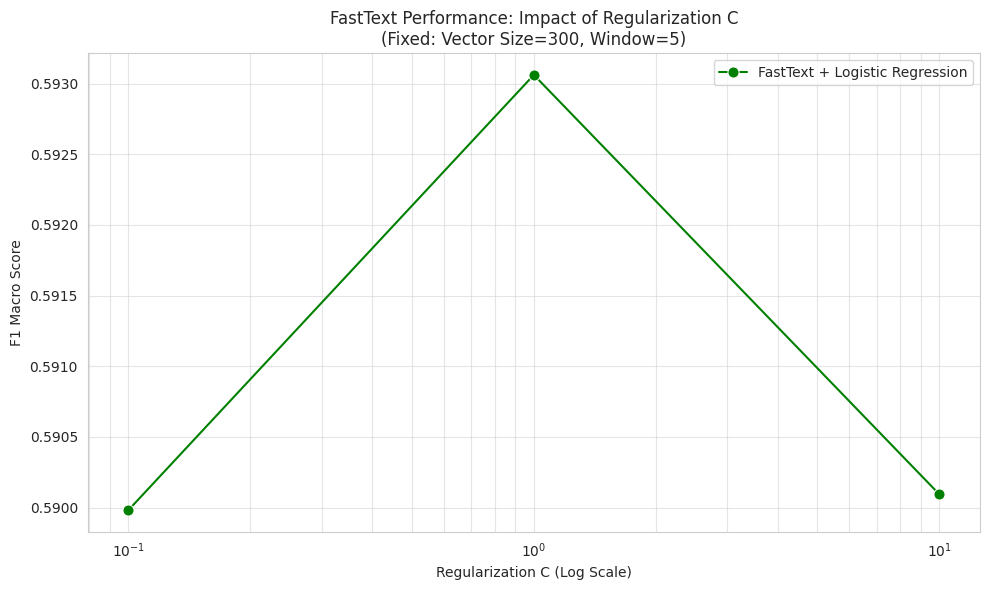

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extraemos los resultados del GridSearch de FastText
df_fasttext = pd.DataFrame(grid_search.cv_results_)

# 2. FILTRADO: Nos quedamos solo con la mejor configuración estructural
# {'vect__vector_size': 300, 'vect__window': 5}
subset_ft = df_fasttext[
    (df_fasttext['param_vect__vector_size'] == 300) &
    (df_fasttext['param_vect__window'] == 5)
]

# 3. GRÁFICA
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset_ft,
    x='param_clf__C',
    y='mean_test_score',
    marker='o',
    markersize=8,
    color='green',  # Usamos verde para distinguir de SVM(rojo)/LR(azul)
    label='FastText + Logistic Regression'
)

plt.xscale('log')
plt.title('FastText Performance: Impact of Regularization C\n(Fixed: Vector Size=300, Window=5)')
plt.xlabel('Regularization C (Log Scale)')
plt.ylabel('F1 Macro Score')
plt.legend(loc='best')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
# print(f"Sparse (TF-IDF) F1-Macro: {sparse_best_score:.4f}")
# print(f"Dense (FastText) F1-Macro:     {dense_best_score:.4f}")

NameError: name 'sparse_best_score' is not defined

# 6. FINAL ERROR ANALYSIS (Section 5)


--- 5 ERROR ANALYSIS ---
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       479
           1       0.77      0.75      0.76       559

    accuracy                           0.75      1038
   macro avg       0.75      0.75      0.75      1038
weighted avg       0.75      0.75      0.75      1038



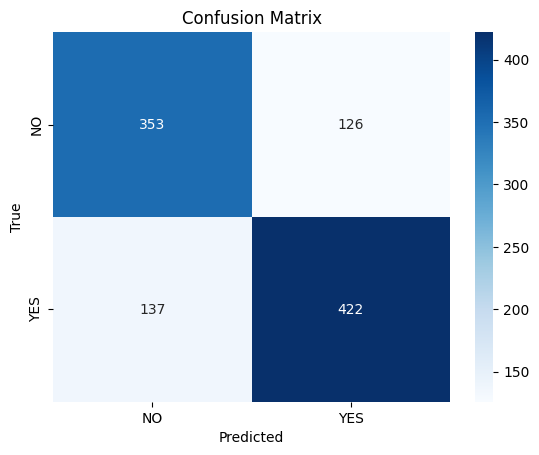


Top 10 Sexist Terms (Positive Weight):
<StringArray>
[    'women',   'mujeres',     'mujer', 'feminismo',       'las',    'hombre',
      'cock',     'whore',      'look',       'men']
Length: 10, dtype: str

Top 10 Safe Terms (Negative Weight):
<StringArray>
[       'co',     'https',    'people', 'womensday',   'deserve',  'igualdad',
      'amor',     'shirt', 'beautiful',   'jornada']
Length: 10, dtype: str

Total Errors: 263
Example Errors (False Negatives - Sexism missed):
<StringArray>
[                                                                                              '@Fichinescu La comunidad gamer es un antro de misóginos y supremacistas blancos hace años pero hoy día pocos se acuerdan de gamergate y todo lo que causó, y en cierto sentido sigue causando.',
                                                                                                                                                                                       '@Ds_OutOfContext Micromachis

In [7]:
# ==========================================
# 6. FINAL ERROR ANALYSIS (Section 5)
# ==========================================
print("\n--- 5 ERROR ANALYSIS ---")
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_val)

print(classification_report(y_val, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Top Discriminative Features
vect = final_model.named_steps['vect']
clf = final_model.named_steps['clf']
feature_names = vect.get_feature_names_out()
coefs = clf.coef_[0]

df_feats = pd.DataFrame({'term': feature_names, 'weight': coefs})
print("\nTop 10 Sexist Terms (Positive Weight):")
print(df_feats.sort_values('weight', ascending=False).head(10)['term'].values)
print("\nTop 10 Safe Terms (Negative Weight):")
print(df_feats.sort_values('weight', ascending=True).head(10)['term'].values)

# Qualitative Analysis
results_val = pd.DataFrame({'text': X_val, 'true': y_val, 'pred': y_pred})
errors = results_val[results_val['true'] != results_val['pred']]
print(f"\nTotal Errors: {len(errors)}")
print("Example Errors (False Negatives - Sexism missed):")
print(errors[errors['true']==1].head(3)['text'].values)

# End of Notebook